In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection_ranked_quadh

signal = ObjIter([Tree(fn) for fn in module.signal_list[::3]])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

In [3]:
bkg = qcd + ttbar

In [4]:
for t in signal:
  t.color = None

In [5]:
def btagmulti(t):
  btags = ak_stack([ t[f'{obj}_btag'] for obj in eightb.quarklist ])
  btagavg = ak.mean(btags,axis=-1)
  multi = { f'n_{label}_btag':ak.sum(btags>wp,axis=-1) for wp,label in zip(jet_btagWP, wplabels) }
  t.extend(btagavg=btagavg, **multi)
(signal+bkg).apply(btagmulti)

[None, None, None, None, None]

In [65]:
eightb.quarklist

['H1Y1_b1',
 'H1Y1_b2',
 'H2Y1_b1',
 'H2Y1_b2',
 'H1Y2_b1',
 'H1Y2_b2',
 'H2Y2_b1',
 'H2Y2_b2']

In [66]:
ak_stack([ signal[0][f'{obj}_ptRegressed'] for obj in eightb.quarklist ])

<Array [[69.1, 27.9, 69, ... 99.9, 83.8, 41.3]] type='44979 * var * float32'>

In [67]:
def rel_jet_pt(t):
  pts = ak_stack([ t[f'{obj}_ptRegressed'] for obj in eightb.quarklist ])
  x_unit = np.sqrt( t.X_m**2 + t.X_pt**2 )
  x_rel_pts = pts/x_unit

  y1_unit = np.sqrt( t.Y1_m**2 + t.Y1_pt**2 )
  y1_rel_pts = pts[:,:4]/y1_unit

  y2_unit = np.sqrt( t.Y2_m**2 + t.Y2_pt**2 )
  y2_rel_pts = pts[:,4:]/y2_unit

  t.extend(x_rel_ht=ak.sum(x_rel_pts,axis=-1), y1_rel_ht=ak.sum(y1_rel_pts,axis=-1), y2_rel_ht=ak.sum(y2_rel_pts,axis=-1))
(signal+bkg).apply(rel_jet_pt)

[None, None, None, None, None]

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


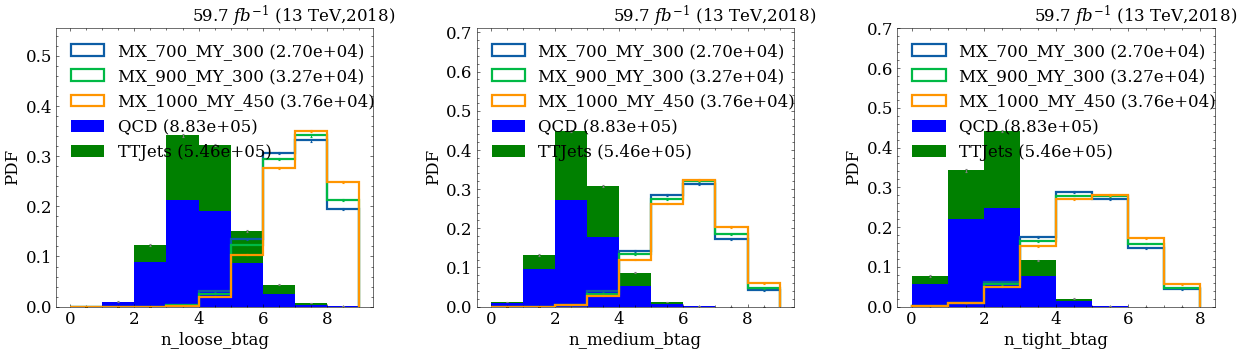

In [68]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
  dim=(-1,3),
  efficiency=True,
  saveas='btagmulti'
)

100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


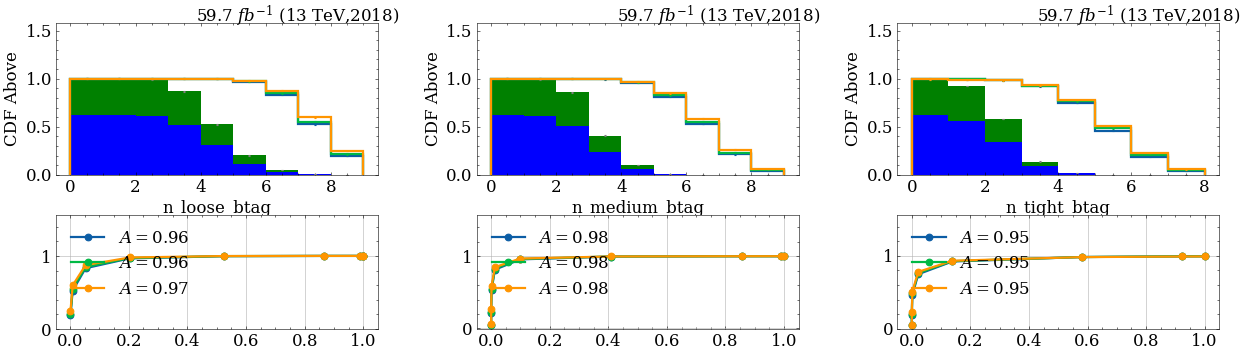

In [69]:

study.quick(
  signal+bkg, stacked=True,
  varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
  dim=(-1,3),
  efficiency=True,
  cumulative=-1,
  correlation=True,
)

100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


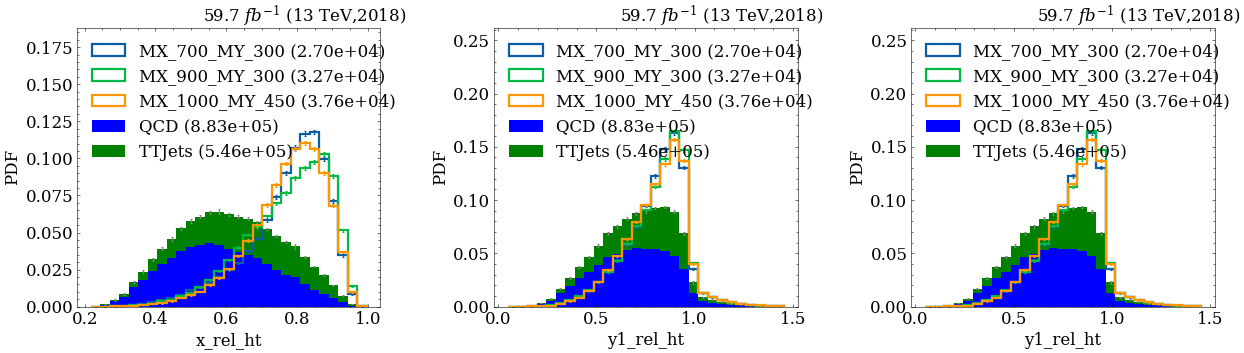

In [72]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['x_rel_ht','y1_rel_ht','y1_rel_ht'],
  dim=(-1,3),
  efficiency=True,
)

100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


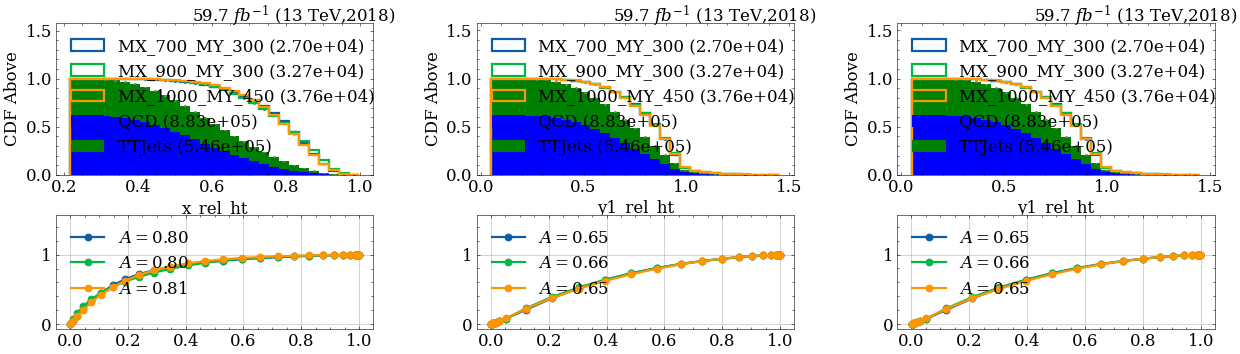

In [73]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['x_rel_ht','y1_rel_ht','y1_rel_ht'],
  dim=(-1,3),
  efficiency=True,
  cumulative=-1,
  correlation=True,
)

In [83]:
xlist = np.linspace(0.,1.0,20)
ylist = np.linspace(0.,1.0,20)  
X, Y = np.meshgrid(xlist, ylist)

In [89]:
yvar = 'rel_ht'
def selections(xvar, figax=None):
  fig, ax = get_figax(figax=figax)
  def sig_eff(x, y):
    mask = lambda t : (t[xvar] >= x) & (t[yvar] >= y)
    return signal.apply(mask).apply(ak.mean).npy.min()
  Z = np.array([ sig_eff(x,y) for x,y in zip(X.flat, Y.flat) ]).reshape(X.shape)
  ax.contourf(X,Y,Z, vmin=0.9)

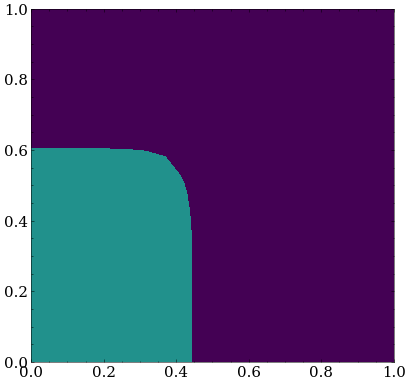

In [90]:
selections('btagavg')


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


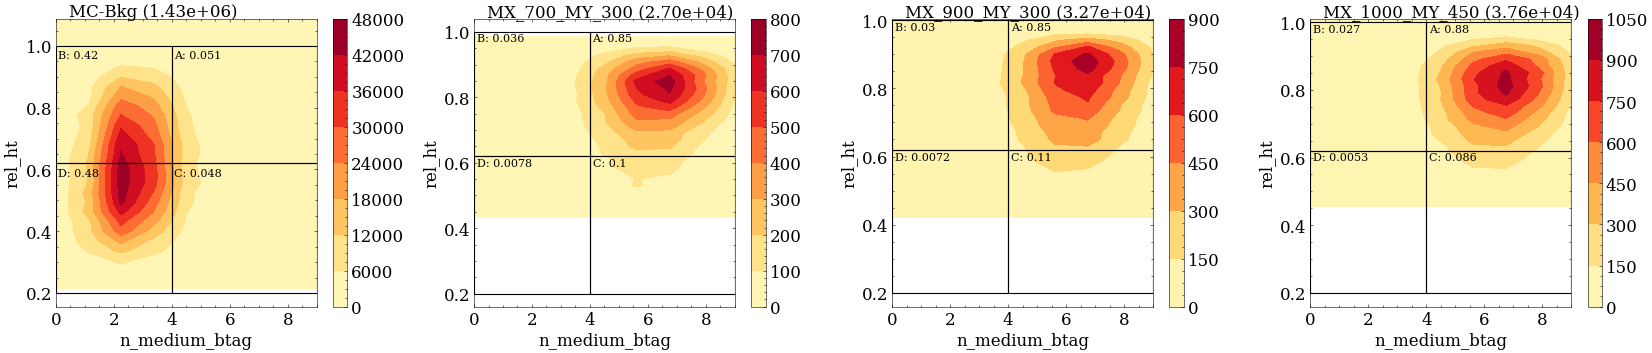

In [106]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(4, dim=(-1,4))

v1 = 'n_medium_btag'
v2 = 'rel_ht'

region = dict(x_r=(0,4,9), y_r=(0.2,0.62,1.0))

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=[v1, v2],
  contour=True,
  figax=(fig,axs[0]),
  exe=draw_abcd(**region)
)

study.quick2d(
  signal,
  varlist=[v1, v2],
  figax=(fig,axs[1:]),
  dim=(-1,3),
  contour=True,
  exe=draw_abcd(**region)
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

In [107]:
def get_abcd_masks(v1_r, v2_r):
  v1_sr = lambda t : (t[v1] >= v1_r[1]) & (t[v1] < v1_r[2])
  v1_cr = lambda t : (t[v1] >= v1_r[0]) & (t[v1] < v1_r[1])

  v2_sr = lambda t : (t[v2] >= v2_r[1]) & (t[v2] < v2_r[2])
  v2_cr = lambda t : (t[v2] >= v2_r[0]) & (t[v2] < v2_r[1])

  r_a = lambda t : v1_sr(t) & v2_sr(t)
  r_b = lambda t : v1_cr(t) & v2_sr(t)

  r_c = lambda t : v1_sr(t) & v2_cr(t)
  r_d = lambda t : v1_cr(t) & v2_cr(t)
  return r_a, r_b, r_c, r_d

def get_region_scale(r):
  t = bkg.apply(lambda t:t.scale).apply(np.sum).npy.sum()
  n = bkg.apply(lambda t:t.scale[r(t)]).apply(np.sum).npy.sum()
  e = np.sqrt(bkg.apply(lambda t:(t.scale[r(t)])**2).apply(np.sum).npy.sum())
  return n/t,e/t


def get_abcd_scale(r_a, r_b, r_c, r_d):
  n_d, e_d = get_region_scale(r_d)
  n_c, e_c = get_region_scale(r_c)
  n_b, e_b = get_region_scale(r_b)
  n_a, e_a = get_region_scale(r_a)

  print(n_a, n_b, n_c, n_d)
  k_factor = n_c/n_d
  e_factor = k_factor*np.sqrt( (e_c/n_c)**2 + (e_d/n_d)**2 )
  k_target = n_a/n_b
  e_target = k_target*np.sqrt( (e_a/n_a)**2 + (e_b/n_b)**2 )

  n_model = k_factor*n_b
  e_model = n_model*np.sqrt( (e_factor/k_factor)**2 )

  return (k_target, e_target), (k_factor, e_factor), (n_model, e_model)

In [108]:
abcd_regions = {
  'nominal':                    [(0,4,9),(0.2,0.62 ,1.0)],
  # 'nominal':                    [(0,0.4,1.0),(0.2,0.6 ,1.0)],
}

In [109]:
region = 'nominal'
v1_r, v2_r = abcd_regions[region]
r_a, r_b, r_c, r_d = get_abcd_masks(v1_r, v2_r)
(k_target, e_target), (k_factor, e_factor), (n_model, e_model) = get_abcd_scale(r_a, r_b, r_c, r_d)

(k_factor, 100*e_factor/k_factor), (k_target/k_factor)

0.05129443423252354 0.4170179669650208 0.048114821951451385 0.4835018729158453


((0.09951320697329727, 2.3893115560808686), 1.2360463457651918)

100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


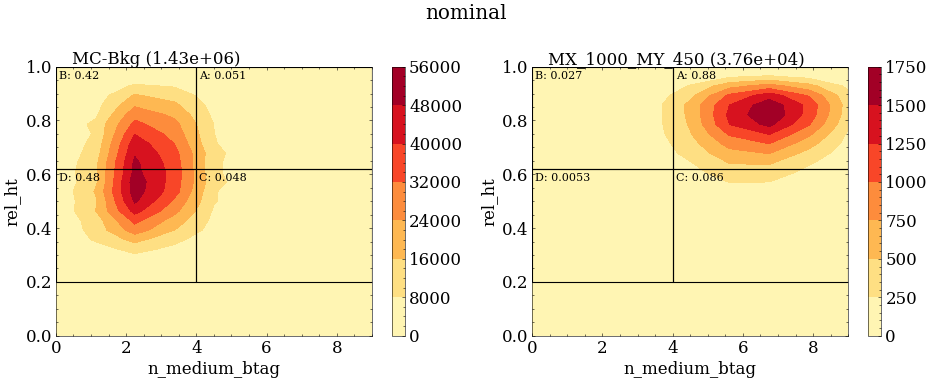

In [114]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(2)

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=[v1, v2],
  binlist=[None, (0,1.0,30)],
  # binlist=[(0,1,30), (0,1.0,30)],
  contour=True,
  figax=(fig,axs[0]),
  dim=(1,1),
  exe=draw_abcd(x_r=v1_r, y_r=v2_r)
)

study.quick2d(
  signal[[-1]],
  varlist=[v1, v2],
  binlist=[None, (0,1.0,30)],
  # binlist=[(0,1,30), (0,1.0,30)],
  figax=(fig,axs[1]),
  dim=(1,1),
  contour=True,
  exe=draw_abcd(x_r=v1_r, y_r=v2_r),
  title=region,
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

In [115]:
(n_model, e_model/n_model)

(0.04149879525817376, 0.023893115560808687)

100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


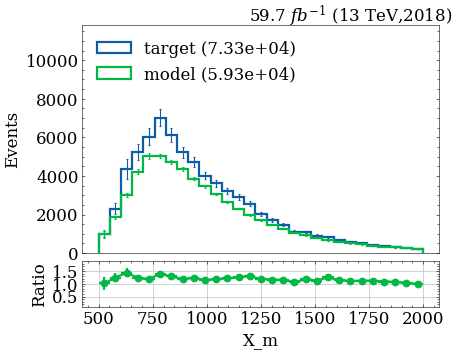

In [116]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',

  ratio=True,

  saveas='model_X_m'
)

In [117]:
ratio = k_target/k_factor
# error = ratio*np.sqrt( (e_target/k_target)**2 + (e_factor/k_factor)**2 )
error = ratio*np.sqrt( (e_factor/k_factor)**2 )

ratio, error/ratio

(1.2360463457651918, 0.023893115560808687)

In [118]:
x = np.linspace(0, 1.5, 1000)
y = f_stats.kstwobign.sf(x)

In [119]:
from scipy import optimize

def f(x):
  return np.abs(f_stats.kstwobign.sf(x) - 0.05)

optimize.fmin(f, 1)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 14
         Function evaluations: 28


array([1.35810547])

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


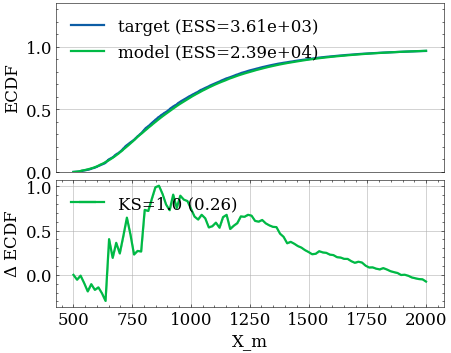

In [120]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'ESS={np.sum(h.weights)**2/np.sum(h.weights**2):0.2e}',

  histo=False,
  empirical=True,
  e_legend=True,
  e_ylim=(0,1.35),

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_kstest'
)

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


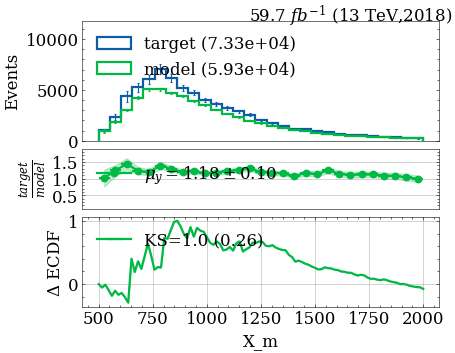

In [121]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',
  legend_loc='upper left',

  ratio=True,
  r_size='50%',
  r_fill_error=True,
  r_ylabel=r'$\frac{target}{model}$',
  r_label_stat='y_mean_std',
  r_legend=True,
  r_legend_loc='upper left',

  empirical=True,
  # e_ylim=(-0.15,1.15),
  e_show=False,

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_full'
)

100%|██████████| 1/1 [00:10<00:00, 10.08s/it]


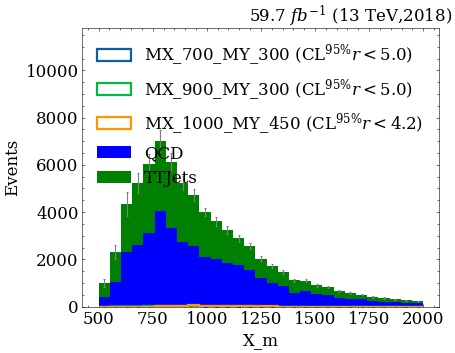

In [122]:
study.quick(
  signal + bkg, 
  varlist=['X_m'], stacked=True, legend=True,
  masks=[r_a]*len(signal) + [r_a]*len(bkg),
  scale=[1e-2]*len(signal) + [1]*len(bkg),
  limits=True,
)

100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


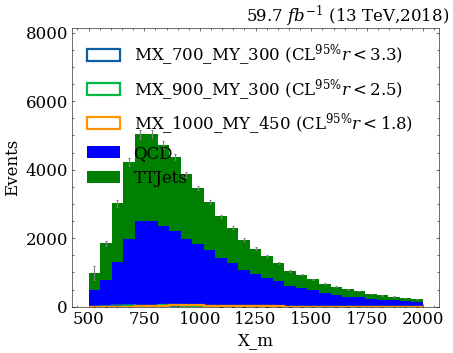

In [123]:
study.quick(
  signal + bkg, 
  varlist=['X_m'], stacked=True, legend=True,
  masks=[r_a]*len(signal) + [r_b]*len(bkg),
  scale=[1e-2]*len(signal) + [k_factor]*len(bkg),
  limits=True,
)